# **Section 2. Architectures of recurrent neural networks**

**Preface**

In the section 1.3 we covered the idea behind of neural network training, using logistic regression as an example. This time we will focus on the neural networks themselves. Due to the fact that the **subject of analysis** is financial time series data, **recurrent neural networks** will be taken into account. The models we propose here are:

*   RNN (Recurrent neural network);
*   LSTM (Long short-term memory);
*   GRU (Gated recurrent unit);

In the light of **theoretical part** the **goal of this chapter** is to explore the unit architecture of these models, to identify their strengths and weaknesses relative to each other. The **practical part** will include manual reconstruction, which will allow us to delve deeper into the details of the computational process and compare the results with automated functions (pytorch).





In [ ]:
import torch
import torch.nn as nn

# **Section 2.1 RNN unit architecture**

Recurrent neural networks are a special kind of deep learning algorithms. In the previous sections, we have considered a variety of architectures, the principles of their training. This time we will consider the recurrent networks themselves and the constructions widely used in the time series analysis.

The vanilla RNN, showed below, is the simplest architecture of this class of models. It is represented by a single equation, which is calculated based on the previous neuron activation value and input data. The activation function shown here is not a strict rule. It can be any other function. Conducting such calculations we estimate the output value for each iteration and pass to it to the next step.

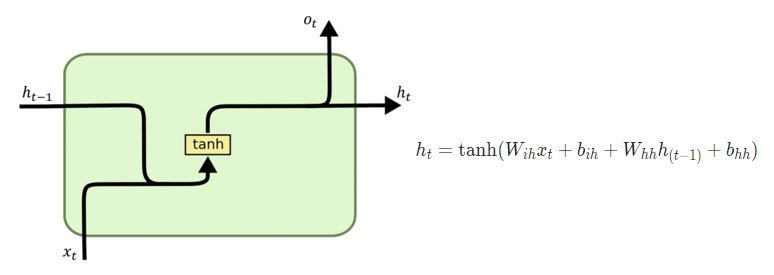

Of course, this type of model can be modified by increasing the number of inputs or the number of hidden states that need to be computed. But how this will be implemented may be not such as obvious as it seems at first glance. That is why the theoretical part of each model is accompanied by practical implementation.

To provide a basic intuition for the implementation of RNN in pytorch, **several cases have been considered**:

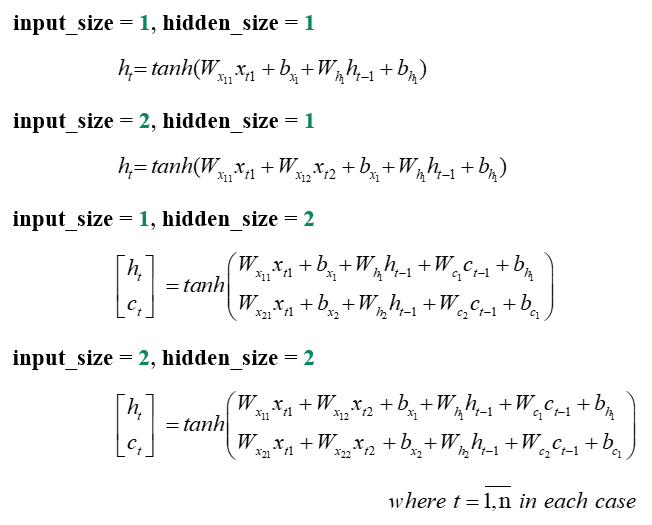

As we can see, given the data structure and the hyperparameter values we set, the calculus inside is different. That's why we need to carefully study the work of automated functions. Looking ahead, it should be noted that the method of storing weight matrices is common for all three models.


**RNN layer construction**

Based on the theory that we discussed above, a custom function of the RNN cell architecture was created. The **purpose of this block** is to show the practical implementation of the knowledge we gained. Note that the default initial value of the hidden state is zero. In the automated version, this line is not displayed in the results, but it is present in our function. The same is true for all custom functions in the document.

In [ ]:
def RNN_cell(x_f, wx_f, wh_f, bx_f = None, bh_f = None):

  #dimensionality check
  if len(x_f.size()) == 3:

    #creating a tensor of hidden states relative to the dimension of the coefficient matrix; 
    h_data = h_lag = torch.zeros((wh_f.shape[1],1))

    #setting the correct shape for biases;
    if None in {bx_f, bh_f}: 
      bx_f = bh_f = torch.zeros((wh_f.shape[1],1))
    else:
      bx_f, bh_f = bx_f.reshape(-1, 1), bh_f.reshape(-1, 1)

    for i in range(x_f.shape[1]):
      #estimation of the hidden states inside the neuron;
      h_lag = torch.tanh(wx_f @ torch.t(x_f[0][[i],:]) + bx_f + wh_f @ h_lag + bh_f) 
      #data collection
      h_data = torch.cat((h_data, h_lag),1)

    print(torch.t(h_data))

  else:
    print("The input must be a 3D tensor. Whereas its shape is: ", x_f.shape)

Using various data structures, we can test the computational performance of the "RNN_cell" function compared to the automated one offered by pytorch.

In [ ]:
seq = torch.FloatTensor([[3, 4], [4, 5], [5, 6]]).unsqueeze(0)

In [ ]:
seq = torch.FloatTensor([[3], [4], [5]]).unsqueeze(0)

In [ ]:
#This time for each hidden layer we would compute two hidden states;
rnn = nn.RNN(input_size=seq.shape[2], hidden_size=2, num_layers = 1, bias = True, batch_first=True)

In [ ]:
#here we get the hidden states, estimated for each value in the sequence; 
out_all, out_last = rnn(seq)
print(out_all)

tensor([[[-0.3900,  0.7115],
         [-0.3220,  0.8536],
         [-0.3124,  0.9051]]], grad_fn=<TransposeBackward1>)


In [ ]:
RNN_cell(seq, rnn.weight_ih_l0.detach(), rnn.weight_hh_l0.detach())

tensor([[ 0.0000,  0.0000],
        [-0.1258,  0.6007],
        [-0.0269,  0.7648],
        [-0.0040,  0.8437]])


In [ ]:
RNN_cell(seq, rnn.weight_ih_l0.detach(), rnn.weight_hh_l0.detach(), rnn.bias_ih_l0.detach(),  rnn.bias_hh_l0.detach())

tensor([[ 0.0000,  0.0000],
        [-0.3900,  0.7115],
        [-0.3220,  0.8536],
        [-0.3124,  0.9051]])


Understanding of how the forward propagation is performed is very important, but we also need to cover the other side of the issue.

In [ ]:
torch.set_printoptions(sci_mode=False)

To update our initial weights, we need to apply the technique we are already familiar with from Section 1.3. In the case of recurrent neural networks, this is called BPTT - back propagation in time. To illustrate how gradients are computed, we will simplify our calculations by using a traditional representation of the RNN model. But before we start, we also need to mention different types of RNN.

Working with time series data, recurrent neural networks have become extremely popular in a number of areas, like: speech recognition, sentiment classification, financial time series prediction, and so on. Depending on the problem we are going to solve, different types of RNNs can be applied. 

In the article published by Afshine Amidi and Shervine Amidi from Standford university, a list of relevant types is provided. In our case, we are going to use the "many-to-one" construction. The unrolled representation of it, is shown below:

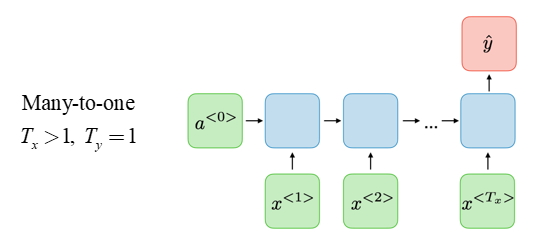

Working with neural networks suggests the use of a huge amount of data. To effectively train the model, we collect observations in the "batches". Technically, it is a 3D tensor consisting of a group of instances from a dataset.

Financial time series, like any other data, must first be transformed to be used in the futher computations. In our case, we want to determine the time frame of previous periods that our network will rely on during training. Then we split the series with respect to this frame, shifting it by one observation per time. As a result, we get a group of sequences. The set of such sequences is nothing but the batches themselves.

Using a many-to-one RNN, we assume that the model's prediction (one period ahead) will be based on information from the previous **n-periods**. For better undertanding of how the gradients are computed, lets consider the case when batch size is relatively small. This will allow us to cover the process of backpropagation of the RNN model and avoid sophisticated calculations, what become evident from the picture below.


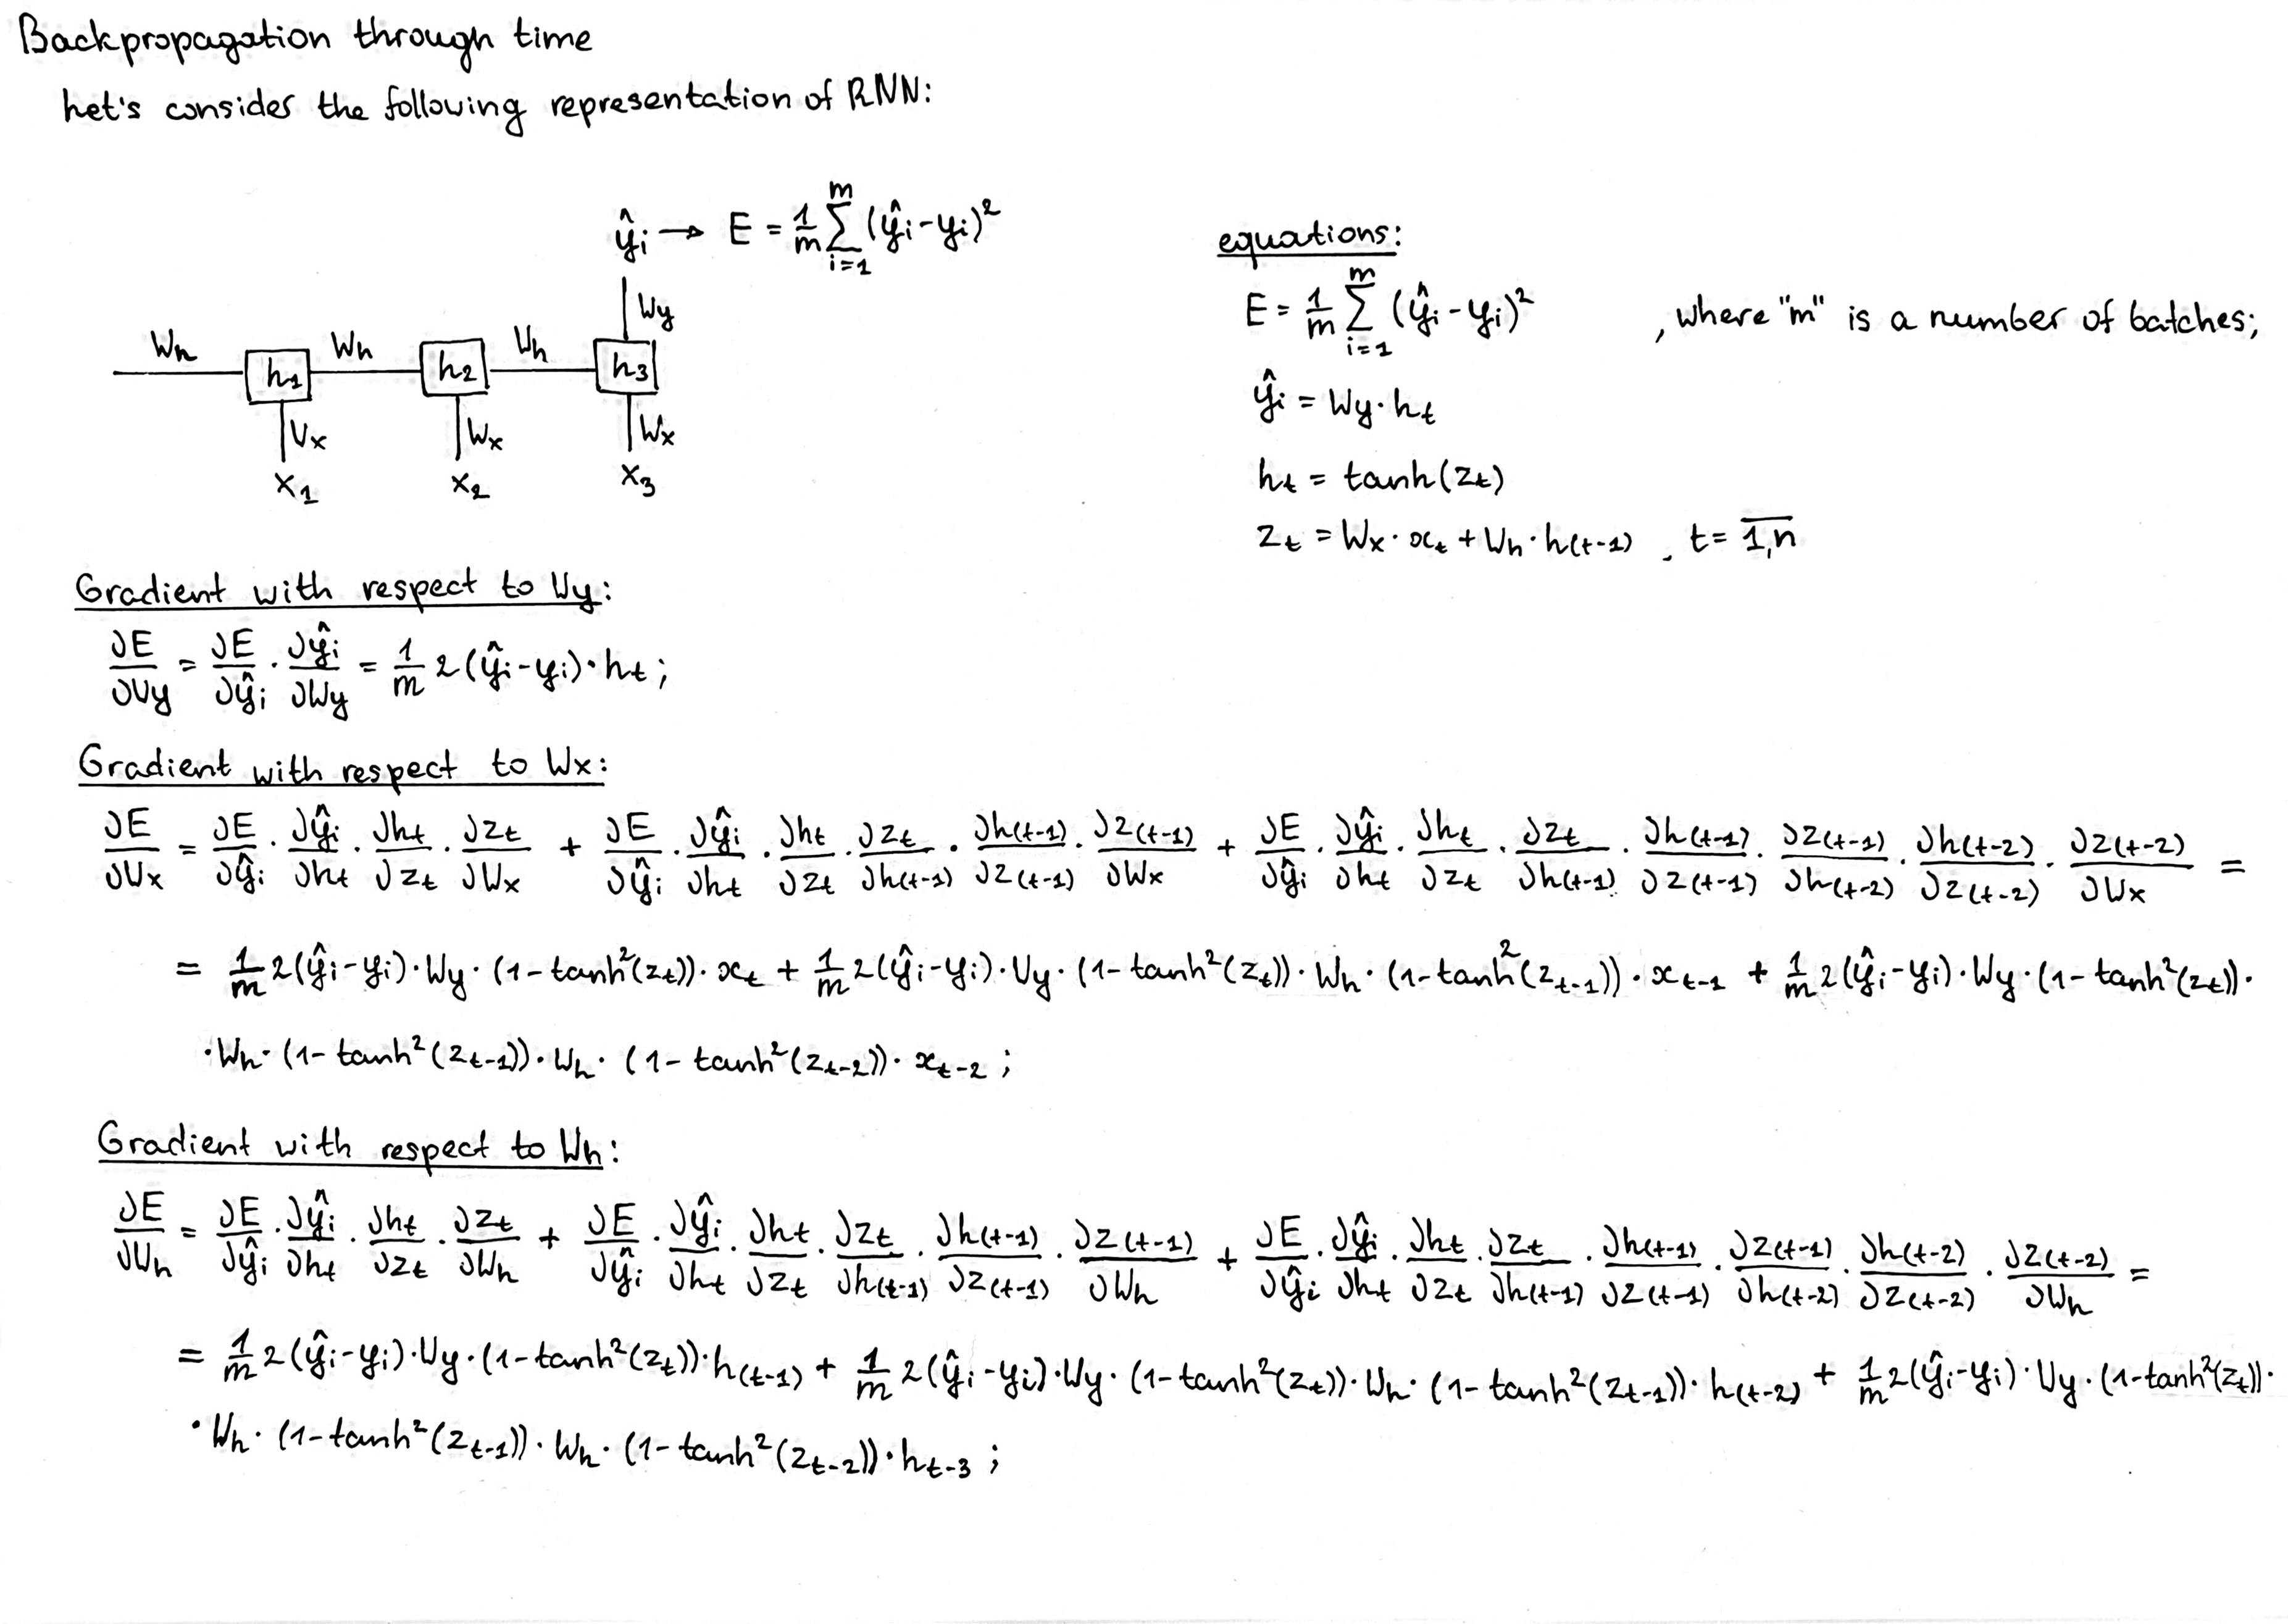

Before we start, we also need to say a few words about the model construction, which consists of recurrent and linear layers. When the purpose of the first one is explained by it’s architecture, the need in the linear layer may be not as obvious at first glance.

At this point we have to remind, that depending on the type of activation function we use, the values are squeezed in a certain range. In the case of the **tanh** function, this is [-1, 1]. It is quite obvious, that the actual series we are going to predict, are not lying in this range. That is why we need to add a linear layer in order to transform the output of the recurrent one.

We also have to note, that both layers are constructed without biases. Thus, the goal of backpropagation is to find the gradients with respect to the weights: "Wx", "Wh", "Wy". The principle is quite the same as we have covered in the section 1.3. The only difference is that this time, the current output depends on both: a current input and a hidden state, which contains the information from the previous periods.

Thus, to calculate the gradient of the loss function with respect to "Wx",  we have to take the partial derivatives for all time steps and sum them up. The same is true for "Wh". The only exception is the weight "Wy", the computation complexity of which does not depend on the length of the sequence and is explained by type of RNN we are using here. It is calculated only once, per batch.





**Automated software:**

In order to proof the math, two sequences were created and stored in the form of batches. Using MSE as the loss function, we also need a data to compare our predictions with. That is why we split the data on "x_train" and "y_train".

In [ ]:
#creating sequences and storing them as batches;
seq1 = torch.FloatTensor([[2], [4], [6], [8]]).unsqueeze(0)
seq2 = torch.FloatTensor([[4], [6], [8], [10]]).unsqueeze(0)

batches = torch.cat([seq1, seq2], dim=0)

#spliting data
x_train = batches[:, :-1, :]
y_train = batches[:, -1, :]

We also created the model class described earlier and named it "RNN_m". Based on it, we created an instance and performed both forward and backward propagations. The code and corresponding results are shown below:

In [ ]:
#model parameters
input_size = x_train.size(2)
hidden_size = 1
num_layers = 1
output_size = 1

In [ ]:
class RNN_m(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size):
    super(RNN_m, self).__init__()
    self.num_layers = num_layers
    self.hidden_size = hidden_size

    self.rnn = nn.RNN(input_size, hidden_size, num_layers, bias = False, batch_first=True)
    self.linear = nn.Linear(hidden_size, output_size, bias = False)

  def forward(self, x):
    #Setting the initial values of hidden states;
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

    #Computation of rnn layer;
    out, _ = self.rnn(x, h0)
    
    #Extracting the last hidden state for each batch and feeding them to the linear layer;
    #This is where we actually define the type of neural network (many-to-one);
    out = self.linear(out[:, -1, :])

    return(out)

In [ ]:
#setting up the Loss function
criterion = nn.MSELoss(reduction='mean')

In [ ]:
#creating an instance of a class "RNN_m";
model = RNN_m(input_size, hidden_size, num_layers, output_size)

In [ ]:
#forward pass;
y_hat = model.forward(x_train)

#loss calculation and backpropagation performing;
Loss = criterion(y_hat, y_train).backward()

In [ ]:
#Gradients for "Wx", "Wh", "Wy" repectively.
print(model.rnn.weight_ih_l0.grad)
print(model.rnn.weight_hh_l0.grad)
print(model.linear.weight.grad)

tensor([[2.7290]])
tensor([[-0.3526]])
tensor([[16.7321]])


Using automated software we gained the gradients for each weight. Note, that we didn`t provide the parameters optimization. Our goal is to show how backpropagation works (BPTT). That's why we wrote an extra chunk of code to do the same calculations manually.

**Manually:**

In [ ]:
#Extraction of weights from the created model;
wx = model.rnn.weight_ih_l0.detach()
wh = model.rnn.weight_hh_l0.detach()
wy = model.linear.weight.detach()

In [ ]:
list_grad = torch.empty(0,3)

m = x_train.size(0) #number of batches;

for i in range(2):
  h0 = 0 #default value for initial hidden state in pytorch;
  h1 = torch.tanh(wx * x_train[i,0] + wh*h0)
  h2 = torch.tanh(wx * x_train[i,1] + wh*h1)
  h3 = torch.tanh(wx * x_train[i,2] + wh*h2)

  yhat = wy*h3
  
  #This type of loss computation looks strange, but explained by the type of RNN we are using;
  #We have two predicted values, one for each batch, so the fraction in front of the loss function will be 1/2;
  #To avoid redundancy, we could take some part of the equation out of the brackets. But the main idea of this code is to perform the exactly the same operations, as in the picture above;
  
  #The only thing, we took out of the brackets is the fraction from the loss function;
  #I believe, that this representation provides better intuition and blurs the line between theory and practice;

  #gradinet with respect to "Wy";
  grad_wy = (2*(yhat-y_train[i,0])*h3)/m
  #gradinet with respect to "Wx";
  grad_wx = (2*(yhat-y_train[i,0])*wy*(1-h3**2)*x_train[i,2] + 2*(yhat-y_train[i,0])*wy*(1-h3**2)*wh*(1-h2**2)*x_train[i,1] + 2*(yhat-y_train[i,0])*wy*(1-h3**2)*wh*(1-h2**2)*wh*(1-h1**2)*x_train[i,0])/m
  #gradinet with respect to "Wh"; 
  grad_wh = (2*(yhat-y_train[i,0])*wy*(1-h3**2)*h2 + 2*(yhat-y_train[i,0])*wy*(1-h3**2)*wh*(1-h2**2)*h1 + 2*(yhat-y_train[i,0])*wy*(1-h3**2)*wh*(1-h2**2)*wh*(1-h1**2)*h0)/m

  #collecting the gradients
  grad = torch.cat((grad_wx, grad_wh, grad_wy),1)
  list_grad = torch.cat((list_grad, grad), 0)

In [ ]:
torch.sum(list_grad, dim = 0).reshape(-1, 1)

tensor([[ 2.7290],
        [-0.3526],
        [16.7321]])

Now we can see a complete match in the results.

**The vanishing gredient problem:**

However, this type of architecture is not capable of storing long-term dependencies. This phenomenon is also known as the **vanishing gradient problem**. After doing some calculations, we can see how the gradients get smaller as we go deeper into the model. This is mainly caused by activation functions and a large number of layers. They become so small that the parameters on the early layers are not updated.



It is easier to understand on other type of networks such as convolutional. But the idea is the following: we can't efficiently store long-term dependencies to use them in our predictions. That is why there was a need for the emergence of new, more complex architectures that can cope with this aspect. These were LSTM and GRU.

# **Section 2.2 LSTM layer construction** 

Introduced in 1997 by Sepp Hochreiter and Jürgen Schmidhuber, LSTM, also known as the long-short memory model, was the first architecture that gained high popularity in the scientific community and has proven itself in a number of areas.

Mainly, when we are working with time series data, we need only a fraction of known information to predict. Suppose that for period "t" we need to use the values of previous periods (not necessarily consecutive), and the same is true for periods "t+1", "t+2" and so on. In order to make the use of a network possible, we need to define a set of relevant data that will be used and updated over time. To ensure this process, a special mechanism was built in: "gates", each of which has its own purpose.

Let us take a look at the picture below:

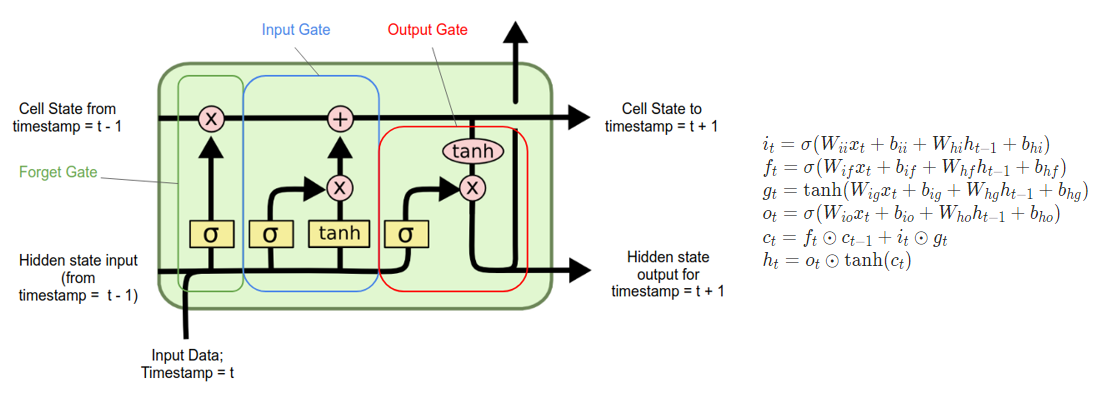

This is a visual representation of the LSTM unit construction. 

**The state in LSTM** is a pair of vectors: "ct" and "ht":

 


*   **ct** - the memory cell, which contains the information of the previous periods;
*   **ht**  - the hidden state at time "t"; the encrypted information of the memory cell "ct";




To understand how these values are estimated, a detailed description of the core elements and calculation process was written:

**Forget gate "ft"** - determines what we need to erase from the memory cell, based on the current input "x(t)" and the hidden state "h(t-1)" evaluated in the previous time step. The **activation function** used in this equation is the sigmoid one we are already familiar with. If the output in some case equals zero, then the value from a particular memory cell is erased.

**Input gate "it"** - defines the magnitute of the new information we add to the memory cell. Thus, the calculation of such data is first carried out. The the theoretical notation of such data is known as **possible candidate "gt"**, where, the tanh activation function is used. The obtained result is then filtered by the input gate, the idea of which is completely similar to that we described earlier.

At this stage, we have everything to **update** the value of the **memory cell "ct"**. Using the Hadamard product described in the equation above, we gain the new memory cell that will be used in futher iteration. But before we do that, we need to find the output value of the current layer (yt = ht). That is where the **output gate** comes in.

**Output gate "ot"** - the filter for the shadow state that determines the output of the current layer. At the begining of the desctiption we mentioned that the state in LSTM is a pair of vectors. We also said, that "ht" is a encrypted information of memory cell "ct". At this point, we can easily verify this by looking at the above equation. As we can see, the memory cell gained on the current step is wrapped into the tanh function and then filtered by the output gate. That is what we have meant by that.

The calculation results in two LSTM states: a new memory cell (**ct**) and its encrypted version (**ht**). The latter is also the output value of the current layer. Both will be used and modified in the further iterations.

**Custom LSTM layer implementation:**

After the theoretical part is over, it will be useful to consolidate the new knowledge in practice. That's why a special custom function: **"LSTM_cell"** was created. We should note that **the main idea** of the practical part is to provide a clear understanding of how the calculus is done. That is why we split the initial tensors of weights into individual ones, in order to use them in a specific equation.

In [ ]:
def LSTM_cell(x_f, wx_f, wh_f, bx_f = None, bh_f = None):

  #dimensionality check
  if len(x_f.size()) == 3:

    #determine the matrices of weights;
    W_ii, W_if, W_ig, W_io = torch.vsplit(wx_f, 4)
    W_hi, W_hf, W_hg, W_ho = torch.vsplit(wh_f, 4)

    #creating a tensor of hidden states and memory cell with respect to the dimension of the coefficient matrix; 
    h_data = h_lag = c_lag = torch.zeros((W_hi.size(1), 1))

    #setting the correct shape for biases;
    if None in {bx_f, bh_f}: 
      bx_f = bh_f = torch.zeros((wh_f.shape[0], 1))
    else:
      bx_f, bh_f = bx_f.reshape(-1, 1), bh_f.reshape(-1, 1)

    #determine the appropriate matrices of biases;
    b_ii, b_if, b_ig, b_io = torch.vsplit(bx_f.reshape(-1, 1), 4)
    b_hi, b_hf, b_hg, b_ho = torch.vsplit(bh_f.reshape(-1, 1), 4)

    for i in range(x_f.size(1)):
      fi = torch.sigmoid(W_ii @ torch.t(x_f[0][[i], :]) + b_ii + W_hi @ h_lag + b_hi) #input gate
      ft = torch.sigmoid(W_if @ torch.t(x_f[0][[i], :]) + b_if + W_hf @ h_lag + b_hf) #forget gate
      gt = torch.tanh(W_ig @ torch.t(x_f[0][[i], :]) + b_ig + W_hg @ h_lag + b_hg) #the candidate

      ot = torch.sigmoid(W_io @ torch.t(x_f[0][[i], :]) + b_io + W_ho @ h_lag + b_ho) #output gate

      c_lag = ft * c_lag + fi * gt #new memory cell
      h_lag = ot * torch.tanh(c_lag) #hidden state estimate
      #data collection
      h_data = torch.cat((h_data, h_lag), 1)

    print(torch.t(h_data))

  else:
    print("The input must be a 3D tensor. Whereas its shape is: ", x_f.shape)

The code contains a relative description to provide more intuition. The method of storing weights by automated function is similar to that, we described earlier in the RNN model. In the code below, we can create the new one or choose among proposed data structures and modify the hyperparameters to compare the result.

In [ ]:
seq = torch.FloatTensor([[3, 4], [4, 5], [5, 6]]).unsqueeze(0)

In [ ]:
seq = torch.FloatTensor([[3], [4], [5]]).unsqueeze(0)

In [ ]:
#This time for each hidden layer we would compute two hidden states;
lstm = nn.LSTM(input_size=seq.shape[2], hidden_size=1, num_layers = 1, bias = True, batch_first=True)

In [ ]:
#here we get the hidden states, estimated for each value in the sequence; 
out_all, out_last = lstm(seq)
print(out_all)

tensor([[[-0.0021],
         [-0.0092],
         [-0.0117]]], grad_fn=<TransposeBackward0>)


In [ ]:
LSTM_cell(seq, lstm.weight_ih_l0.detach(), lstm.weight_hh_l0.detach())

tensor([[ 0.0000],
        [-0.0653],
        [-0.0671],
        [-0.0528]])


In [ ]:
LSTM_cell(seq, lstm.weight_ih_l0.detach(), lstm.weight_hh_l0.detach(), lstm.bias_ih_l0.detach(), lstm.bias_hh_l0.detach())

tensor([[ 0.0000],
        [-0.0021],
        [-0.0092],
        [-0.0117]])


As we can see the results are absolutely equivalent. Thus, we consolidated the acquired knowledge in practice.

The last thing we want to point out is some **architectural issues** of LSTM:

When we evaluate gates, we don't count them based on full information (ct), but on a filtered version of memory (ht). There is a conceptual problem here. Even if we take this for granted, it becomes strange that in the case of the output gate (ot) we do not take into account the new memory cell (ct) calculated at the current step.

This problem has been mentioned by the scientific community. That is why a new, updated version of the LSTM was proposed a few years after the main article was published. It is called **"LSTM with peephole connections"**.

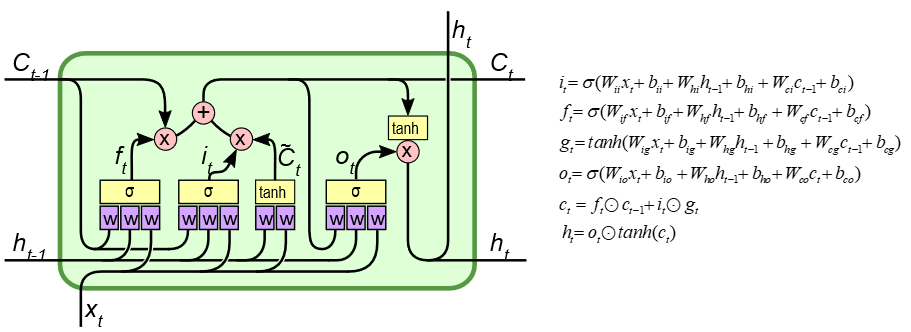

We simply added the cell memory inside these gates. Note, that the **output gate "ot"** now contains **"ct"** of the current state, which solves the problem we described above.

# **Section 2.3 GRU layer construction**

For a long time LSTM remained the popular choice in the context of times series modeling. Multiple times, the scientific comunity tried to outperform the results of this model, looking for a new architectures. Finding the right construction is an extremely difficult task, because the new model must perform well not in a single example, but in various areas. 

Only in 2014 the new model was introduced. **"GRU"**, or **"Gated Reccurent Unit"** - the algorithim, that in pretty similar to the one, we used in the previous section. This type of hidden unit construction has been motivated by the LSTM itself, which is noted in the original article.

The clear **advantages of the GRU** are the reduction in the number of gates, the simplification of the model architecture, and the merging of the memory cell and its encrypted form of it - now, they are one entity.


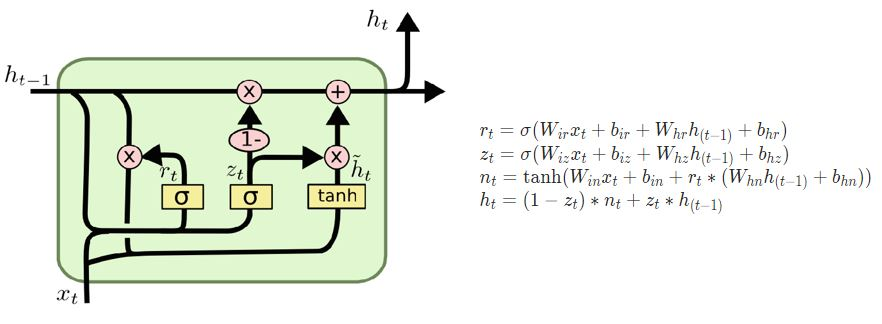

Let us describe how the activation of the hidden unit is computed: 

**Reset gate "rt"** - selects the relevant information from the previous state **h(t-1)**, given the new input **x(t)**; Due to the fact that both LSTM and GRU are capable of storing long-running dependencies, not all information stored in **h(t-1)** is needed at a particular time step.

It reminds me the approach of seasonal arima, where in addition to the basic coefficions, the seasonal ones are used. This means that we are relying on previous observations, which are not a necessary sequential. The idea of this gate is to determine lagging values that will be useful for the current time step.

**Update gate "zt"**  - controls how much information from the previous state **h(t-1)** will carry over to new one **h(t)**. As we can see from the equations above, to compute the candidate of the current state **"nt"**, we use: input **x(t)**, previous state **h(t-1)** and the reset gate **"rt"** which takes values from [0,1]. Evidently, that the candidate contains the new, but also the old information. Thus, our goal is to find the compromise, the portion of **h(t-1)** and **n(t)** to be embedded in the final state **h(t)**. That is what the update gate actually does.



**Custom GRU layer implementation:**

Finally, we finished the theoretical part. Let`s take a look at the practical representation.

In [ ]:
def GRU_cell(x_f, wx_f, wh_f, bx_f = None, bh_f = None):
  
  #dimensionality check
  if len(x_f.size()) == 3:

    #determine the appropriate matrices for the equations;
    wx1 , wx2, wx3 = torch.vsplit(wx_f, 3)
    wr, wz, wn = torch.vsplit(wh_f, 3)

    #creating a tensor of hidden states with respect to the dimension of the coefficient matrix; 
    h_data = h_lag = torch.zeros((wr.size(1), 1))

    #setting the correct shape for biases;
    if None in {bx_f, bh_f}: 
      bx_f = bh_f = torch.zeros((wh_f.shape[0], 1))
    else:
      bx_f, bh_f = bx_f.reshape(-1, 1), bh_f.reshape(-1, 1)
    
    #split biases according to the equations;
    bx1, bx2, bx3 = torch.vsplit(bx_f, 3)
    bh1, bh2, bh3 = torch.vsplit(bh_f, 3)

    for i in range(x_f.size(1)):
      rt = torch.sigmoid(wx1 @ torch.t(x_f[0][[i],:]) + bx1 + wr @ h_lag + bh1) #reset gate;
      zt = torch.sigmoid(wx2 @ torch.t(x_f[0][[i],:]) + bx2 + wz @ h_lag + bh2) #update gate;

      nt = torch.tanh(wx3 @ torch.t(x_f[0][[i],:]) + bx3 + rt * (wn @ h_lag  + bh3)) #hidden state candidate;
      h_lag = (1 - zt) * nt + zt * h_lag #hidden state itself;
      #data collection
      h_data = torch.cat((h_data, h_lag), 1)

    print(torch.t(h_data))
    
  else:
    print("The input must be a 3D tensor. Whereas its shape is: ", x_f.shape)

In [ ]:
seq = torch.FloatTensor([[3, 4], [4, 5], [5, 6]]).unsqueeze(0)

In [ ]:
seq = torch.FloatTensor([[3], [4], [5]]).unsqueeze(0)

In [ ]:
#This time for each hidden layer we would compute two hidden states;
gru = nn.GRU(input_size=seq.shape[2], hidden_size=1, num_layers = 1, bias = True, batch_first=True)

In [ ]:
#here we get the hidden states, estimated for each value in the sequence; 
out_all, out_last = gru(seq)
print(out_all)

tensor([[[0.4847],
         [0.6419],
         [0.6575]]], grad_fn=<TransposeBackward1>)


In [ ]:
GRU_cell(seq, gru.weight_ih_l0.detach(), gru.weight_hh_l0.detach())

tensor([[ 0.0000],
        [-0.0597],
        [-0.0916],
        [-0.1180]])


In [ ]:
GRU_cell(seq, gru.weight_ih_l0.detach(), gru.weight_hh_l0.detach(), gru.bias_ih_l0.detach(), gru.bias_hh_l0.detach())

tensor([[0.0000],
        [0.4847],
        [0.6419],
        [0.6575]])


**The last remark of GRU model:**

This architecture allows us to contain and update relevant information, capture short-term and long-term dependencies, and provide the desired result. Like LSTM, it also **solves the vanishing gradient problem**, but has fewer parameters, making it computationally efficient. These days, GRU became a real competitor of LSTM. In practice, analysts prefer to use both models, because depending on the subject of analysis, the performance of the models may vary. Despite this, they are considered stable and clearly deserve attention from the scientific community.

# **Summary**

Forecasting time series data is a challenging task. Even though the observations are collected at regular intervals, in the case of stock market prediction, where everything can change in a split second, this becomes a headache that we have know how to deal with. The basic algorithms like Arima, Sarima, Arch and Garch models can`t efficiently perform in the case of volatility which is a regular thing in the stock marker.

That is why there is a growing interest in the data science community for algorithms that are more powerful and more tough in terms of mathematics. The special attention is paid to the field of deep learning in particular to recurrent neural networks. Unlike their predecessors, they are multitasking and easily cope with thing that are beyond the capabilities of the mentioned models.

Vanilla RNN is not among those models commonly used for forecasting purposes. The main reason for this is the inability to store long-term dependencies and the vanishing-gredient problem - a case where the parameters don't train due to the hue gradient. But it is a great learning material and a starting point for more complex recurrent neural network architectures.

Modern architectures such as GRU and LSTM are excellent for forecasting financial time series, in particular company stocks and other securities. Both proved to be effective and thus justified their computational cost.

